# Multi-Objective Bayesian Optimization for Retail Promotions

**Author:** Tobin Ireland  
**Course:** Imperial Capstone Project  

**Objective:**  
Predict the best product, price, and promotional offer for each customer to maximize **Customer Lifetime Value (CLV)** using **Bayesian Optimization**.

**Dataset:** `online_retail_II_sample.csv` (first 500 rows from UCI Online Retail II dataset)  
Columns include: `InvoiceNo`, `StockCode`, `Description`, `Quantity`, `InvoiceDate`, `UnitPrice`, `CustomerID`, `Country`.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Bayesian Optimization
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load sample dataset
file_path = "../data/raw/online_retail_II_sample.csv"
df = pd.read_csv(file_path)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (500, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Goal is maximizing customer lifetime profitability (next best promotion/product/price), we need to define:

Decision variables: product, promotion type, price

Objective function: predicted profit (or some proxy)

Bounds/categories: what values each variable can take

For simplicity, let’s define an example function.

In [4]:
# Example: Define the search space
space = [
    Categorical(['Product_A', 'Product_B', 'Product_C'], name='product'),
    Categorical(['Discount_5%', 'Discount_10%', 'No_Discount'], name='promotion'),
    Real(5, 100, name='price')  # price in dollars
]

# Example objective function
def objective(params):
    product, promotion, price = params
    
    # Simplified mock function: profit = random + simple rules
    profit = 0
    if product == 'Product_A':
        profit += 10
    elif product == 'Product_B':
        profit += 15
    else:
        profit += 8

    if promotion == 'Discount_10%':
        profit += 5
    elif promotion == 'Discount_5%':
        profit += 2

    profit -= 0.1 * price  # higher price reduces likelihood of purchase
    
    return -profit  # gp_minimize **minimizes**, so we use negative profit


In [5]:
# Run Bayesian Optimization
result = gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=20,  # number of iterations
    random_state=42
)

# Print results
best_params = result.x
best_profit = -result.fun

print("Best Parameters:", best_params)
print("Expected Profit:", best_profit)


Best Parameters: [np.str_('Product_B'), np.str_('Discount_10%'), 5.0]
Expected Profit: 19.5


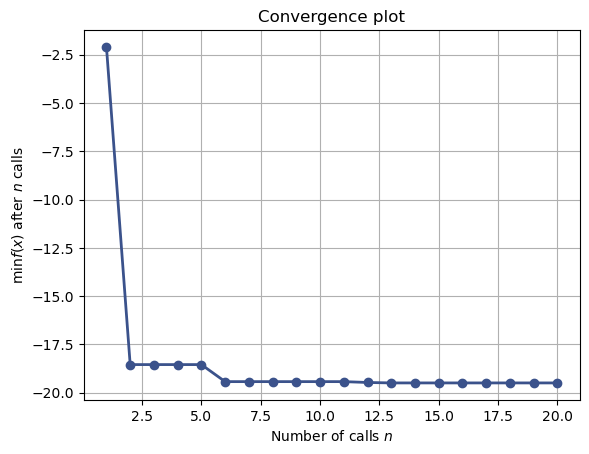

In [6]:
# Plot convergence
from skopt.plots import plot_convergence
plot_convergence(result)
plt.show()


Full simulation

We need a target variable (profit) and features (product, price, promotion type).

Assume you have columns:

CustomerID

StockCode (product)

Quantity

UnitPrice

InvoiceDate

We’ll define a simple proxy for profit per transaction:

In [8]:
# Check the column names
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [9]:
# Example: calculate profit per row
df['Profit'] = df['Quantity'] * df['Price']

# Optional: encode promotion as a new column (simplified)
# Here we randomly assign promotions for demonstration
np.random.seed(42)
df['Promotion'] = np.random.choice(['Discount_5%', 'Discount_10%', 'No_Discount'], size=len(df))

# Quick look
df[['StockCode', 'Price', 'Quantity', 'Promotion', 'Profit']].head()


,StockCode,Price,Quantity,Promotion,Profit
0,85123A,2.55,6,No_Discount,15.30
1,71053,3.39,6,Discount_5%,20.34
2,84406B,2.75,8,No_Discount,22.00
3,84029G,3.39,6,No_Discount,20.34
4,84029E,3.39,6,Discount_5%,20.34


In [10]:
# Map promotions to integers
promotion_mapping = {'No_Discount': 0, 'Discount_5%': 1, 'Discount_10%': 2}
df['Promotion_encoded'] = df['Promotion'].map(promotion_mapping)

# Check
df[['Promotion', 'Promotion_encoded']].head()

,Promotion,Promotion_encoded
0,No_Discount,0
1,Discount_5%,1
2,No_Discount,0
3,No_Discount,0
4,Discount_5%,1


Suppose our goal is to maximize profit per transaction by choosing the best Price and Promotion. Bayesian optimization minimizes a function, so we define the objective as negative profit:

In [11]:
# Objective function to maximize profit
def objective(params):
    price, promotion_code = params
    # For simplicity, we'll assume profit = price * quantity for this sample
    # Select rows with closest promotion_code
    promotion_rows = df[df['Promotion_encoded'] == int(promotion_code)]
    
    if len(promotion_rows) == 0:
        return 0  # Avoid empty selection
    
    # Calculate average profit for given price and promotion
    avg_profit = np.mean((price * promotion_rows['Quantity']))
    
    # Bayesian optimization minimizes, so return negative profit
    return -avg_profit

We tell Bayesian optimization which values to search for:

In [12]:
from skopt.space import Real, Integer

# Define ranges
space = [
    Real(0.5, 50.0, name='price'),              # Price between 0.5 and 50
    Integer(0, 2, name='promotion_code')        # 0=No Discount, 1=5%, 2=10%
]

In [13]:
from skopt import gp_minimize

# Run optimization
result = gp_minimize(
    func=objective,   # Objective function
    dimensions=space, # Search space
    n_calls=20,       # Number of evaluations
    random_state=42
)

# Best parameters
best_price, best_promotion_code = result.x
best_profit = -result.fun

promotion_name = [k for k, v in promotion_mapping.items() if v == best_promotion_code][0]

print(f"Optimal Price: {best_price}")
print(f"Optimal Promotion: {promotion_name}")
print(f"Expected Profit: {best_profit:.2f}")


Optimal Price: 50.0
Optimal Promotion: Discount_5%
Expected Profit: 908.04


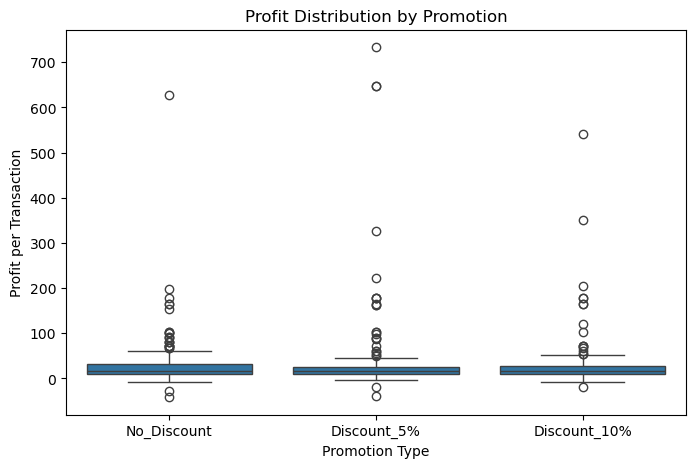

In [14]:
# Profit distribution per promotion
plt.figure(figsize=(8,5))
sns.boxplot(x='Promotion', y='Profit', data=df)
plt.title("Profit Distribution by Promotion")
plt.ylabel("Profit per Transaction")
plt.xlabel("Promotion Type")
plt.show()


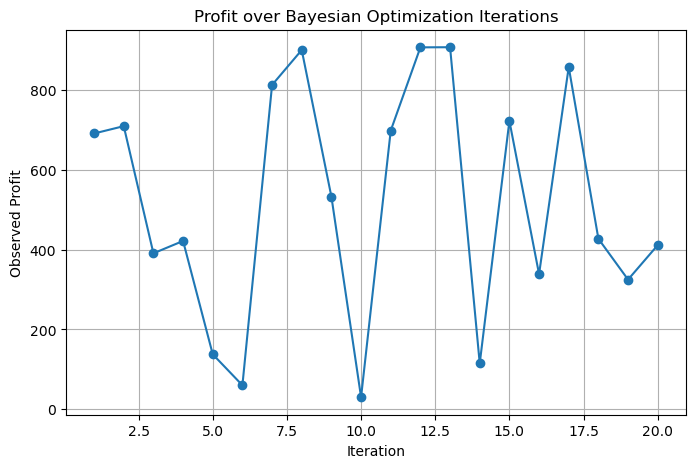

In [15]:
# Extract function values
profits_observed = [-val for val in result.func_vals]  # convert back to profit

plt.figure(figsize=(8,5))
plt.plot(range(1, len(profits_observed)+1), profits_observed, marker='o')
plt.title("Profit over Bayesian Optimization Iterations")
plt.xlabel("Iteration")
plt.ylabel("Observed Profit")
plt.grid(True)
plt.show()


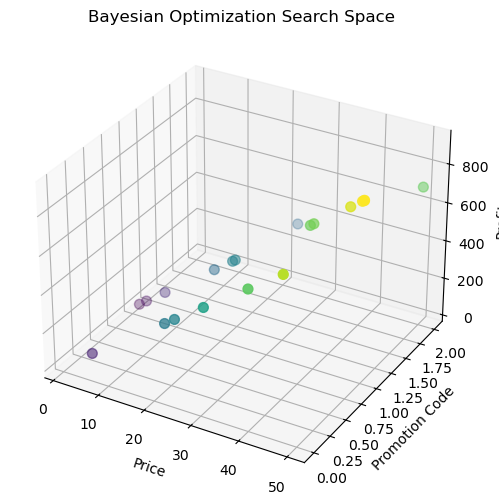

In [16]:
from mpl_toolkits.mplot3d import Axes3D

prices = [x[0] for x in result.x_iters]
promotions = [x[1] for x in result.x_iters]
profits = profits_observed

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(prices, promotions, profits, c=profits, cmap='viridis', s=50)
ax.set_xlabel("Price")
ax.set_ylabel("Promotion Code")
ax.set_zlabel("Profit")
plt.title("Bayesian Optimization Search Space")
plt.show()
